In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-21 14:56:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.07s   

2023-09-21 14:56:01 (19.8 MB/s) - ‘housing.csv’ saved [1423529/1423529]



*EDA*

In [2]:
import pandas as pd

housing = pd.read_csv("housing.csv")

<Axes: xlabel='median_house_value', ylabel='Count'>

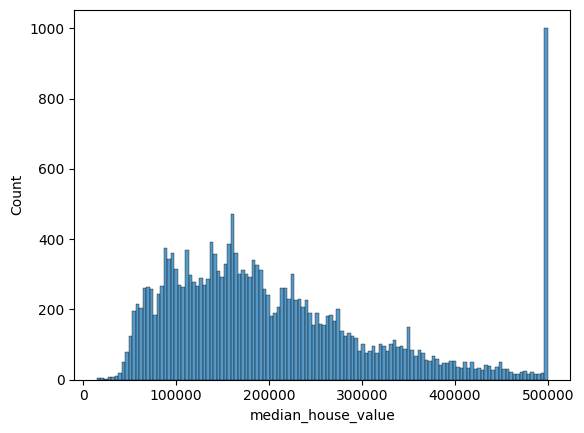

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=housing, x='median_house_value', bins=128)

Yes, the distribution of the target variable is long-tailed. It also has a high peak at the end, so probably the values beyond that specific values (approximately 500k$) are clipped.

*Preparing the dataset*

In [4]:
housing = housing[housing['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
housing = housing[
    ['latitude', 'longitude', 'housing_median_age',
    'total_rooms', 'total_bedrooms', 'population',
    'households', 'median_income', 'median_house_value']
]

housing.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


Question #1

In [5]:
housing.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

Question #2

In [6]:
housing['population'].median()

1195.0

*Prepare and split the dataset*

In [41]:
import numpy as np

np.random.seed(42)

housing.reset_index(drop=True, inplace=True)
indices = np.arange(housing.shape[0])
np.random.shuffle(indices)

housing_shuffled = housing.iloc[indices]
housing_shuffled

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
15183,36.23,-119.14,22.0,2935.0,523.0,1927.0,530.0,2.5875,70400.0
4469,34.12,-117.79,16.0,2426.0,426.0,1319.0,446.0,4.8125,224500.0
9316,33.68,-117.97,26.0,3653.0,568.0,1930.0,585.0,5.7301,260900.0
4983,34.10,-118.03,32.0,2668.0,609.0,1512.0,541.0,2.9422,233100.0
13154,37.34,-121.87,39.0,2479.0,541.0,1990.0,506.0,2.4306,289100.0
...,...,...,...,...,...,...,...,...,...
5191,34.15,-118.14,41.0,1256.0,407.0,855.0,383.0,1.9923,500001.0
13418,37.40,-121.86,19.0,4043.0,764.0,2196.0,708.0,6.1504,268400.0
5390,34.07,-118.15,52.0,1983.0,344.0,887.0,331.0,3.2875,234400.0
860,36.78,-119.81,37.0,1965.0,364.0,796.0,335.0,3.6250,83400.0


In [89]:
idx_train = int(0.6 * housing_shuffled.shape[0])
idx_val = idx_train + int(0.2 * housing_shuffled.shape[0])
idx_test = housing_shuffled.shape[0]

housing_train = housing_shuffled[:idx_train]
housing_val = housing_shuffled[idx_train:idx_val]
housing_test = housing_shuffled[idx_val:idx_test]

X_train, y_train = housing_train.drop('median_house_value', axis=1), housing_train[['median_house_value']]
X_val, y_val = housing_val.drop('median_house_value', axis=1), housing_val[['median_house_value']]
X_test, y_test = housing_test.drop('median_house_value', axis=1), housing_test[['median_house_value']]

y_train = y_train.apply(np.log1p)
y_val = y_val.apply(np.log1p)
y_test = y_test.apply(np.log1p)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

**Question 3**

In [134]:
def fill_na(X, value=0):
    X = X.copy()

    nan_mask = np.isnan(X)
    X[nan_mask] = value
    return X

def train_linear_regression(X, y):

    X_full = np.column_stack((np.ones(X.shape[0]), X))
    return np.linalg.inv(X_full.T @ X_full) @ X_full.T @ y

def predict(X, w):

    X_full = np.column_stack((np.ones(X.shape[0]), X))
    return X_full @ w

def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square((y - y_pred))))

fill_methods = ('zeros', 'mean')
for fill_method in fill_methods:

    if fill_method == 'zeros':
        w = train_linear_regression(fill_na(X_train, 0), y_train)
        y_pred = predict(fill_na(X_val, 0), w)
    elif fill_method == 'mean':
        w = train_linear_regression(fill_na(X_train, np.nanmean(X_train)), y_train)
        y_pred = predict(fill_na(X_val, np.nanmean(X_train)), w)

    print(f'{fill_method}: {round(rmse(y_val, y_pred), 2)}')

zeros: 0.34
mean: 0.34


**Question #4**

In [136]:
def train_linear_regression_l2(X, y, alpha=0.1):

    X_full = np.column_stack((np.ones(X.shape[0]), X))
    return np.linalg.inv(X_full.T @ X_full + np.diag(np.full(X_full.shape[1], alpha))) @ X_full.T @ y

for alpha in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w = train_linear_regression_l2(fill_na(X_train, 0), y_train, alpha)
    y_pred = predict(fill_na(X_val, 0), w)

    print(f'{alpha}: {round(rmse(y_val, y_pred), 2)}')

0: 0.34
1e-06: 0.34
0.0001: 0.34
0.001: 0.34
0.01: 0.34
0.1: 0.34
1: 0.34
5: 0.35
10: 0.35


**Question #5**

In [138]:
errors = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    np.random.seed(seed)

    housing.reset_index(drop=True, inplace=True)
    indices = np.arange(housing.shape[0])
    np.random.shuffle(indices)

    housing_shuffled = housing.iloc[indices]
    idx_train = int(0.6 * housing_shuffled.shape[0])
    idx_val = idx_train + int(0.2 * housing_shuffled.shape[0])
    idx_test = housing_shuffled.shape[0]

    housing_train = housing_shuffled[:idx_train]
    housing_val = housing_shuffled[idx_train:idx_val]
    housing_test = housing_shuffled[idx_val:idx_test]

    X_train, y_train = housing_train.drop('median_house_value', axis=1), housing_train[['median_house_value']]
    X_val, y_val = housing_val.drop('median_house_value', axis=1), housing_val[['median_house_value']]
    X_test, y_test = housing_test.drop('median_house_value', axis=1), housing_test[['median_house_value']]

    y_train = y_train.apply(np.log1p)
    y_val = y_val.apply(np.log1p)
    y_test = y_test.apply(np.log1p)

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    w = train_linear_regression(fill_na(X_train, 0), y_train)
    y_pred = predict(fill_na(X_val, 0), w)

    errors.append(rmse(y_val, y_pred))

round(np.std(errors), 3)

0.006

**Question 7**

In [ ]:
np.random.seed(9)

housing.reset_index(drop=True, inplace=True)
indices = np.arange(housing.shape[0])
np.random.shuffle(indices)

housing_shuffled = housing.iloc[indices]
idx_train = int(0.6 * housing_shuffled.shape[0])
idx_val = idx_train + int(0.2 * housing_shuffled.shape[0])
idx_test = housing_shuffled.shape[0]

housing_train = housing_shuffled[:idx_train]
housing_val = housing_shuffled[idx_train:idx_val]
housing_test = housing_shuffled[idx_val:idx_test]

X_train, y_train = housing_train.drop('median_house_value', axis=1), housing_train[['median_house_value']]
X_val, y_val = housing_val.drop('median_house_value', axis=1), housing_val[['median_house_value']]
X_test, y_test = housing_test.drop('median_house_value', axis=1), housing_test[['median_house_value']]

y_train = y_train.apply(np.log1p)
y_val = y_val.apply(np.log1p)
y_test = y_test.apply(np.log1p)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [144]:
X_train_full = np.concatenate((X_train, X_val), axis=0)
y_train_full = np.concatenate((y_train, y_val), axis=0)

w = train_linear_regression_l2(fill_na(X_train_full, 0), y_train_full, 0.001)
y_pred = predict(fill_na(X_test, 0), w)

round(rmse(y_test, y_pred), 2)

0.33